In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.spatial import KDTree
from scipy.stats import truncnorm

In [2]:
import numpyro
from numpyro.handlers import seed, substitute, trace
from jax import random
from celestify.numpyro_models import HierarchicalStarModel

2024-02-01 16:36:57.498078: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-01 16:36:57.498106: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-01 16:36:57.499146: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-01 16:36:58.080168: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Holoviews not imported. Some visualizations will not be available.
PyMultiNest not imported.  MultiNest fits will not work.


In [12]:
num_stars = 10000
rng = random.PRNGKey(0)

true_model = HierarchicalStarModel(num_stars)

truths = {
    "mu_a": 2.0,
    "sigma_a": 0.1,
    "Y_0": 0.247,
    "dY_dZ": 1.5,
    "sigma_Y": 0.008,
}

rng, key = random.split(rng)
true_trace = trace(seed(substitute(true_model, truths), key)).get_trace()
truths.update({k: np.array(v["value"]) for k, v in true_trace.items()})

In [15]:
filename = "/mnt/data-storage/yaguangli2023/stellar-models/grid_models_surface_effect_uncorrected/dataset.h5"
test = pd.read_hdf(filename, "test")
test.head()

,track,star,star_mass,Yinit,Zinit,amlt,fov_core,fov_shell,star_age,radius,...,log_g,log_L,delta_X,f_nuc,phase,EEP,bol_mag,abs_G,abs_BP,abs_RP
7,7000,8,0.92329,0.279311,0.001829,1.608258,0.0,0.006041,5.405171e+07,0.898494,...,4.496376,0.078459,0.003644,1.000889,0,0.001982,4.553852,4.538610,4.761750,4.151341
22,7000,23,0.92329,0.279311,0.001829,1.608258,0.0,0.006041,7.720014e+08,0.927802,...,4.468495,0.116195,0.079764,0.999808,0,0.022920,4.459513,4.444757,4.663875,4.062834
24,7000,25,0.92329,0.279311,0.001829,1.608258,0.0,0.006041,8.675000e+08,0.931258,...,4.465266,0.120890,0.090904,0.999808,0,0.025527,4.447776,4.433104,4.651625,4.051969
25,7000,26,0.92329,0.279311,0.001829,1.608258,0.0,0.006041,9.247991e+08,0.933354,...,4.463313,0.123724,0.097724,0.999807,0,0.027101,4.440689,4.426066,4.644227,4.045407
30,7000,31,0.92329,0.279311,0.001829,1.608258,0.0,0.006041,1.184983e+09,0.943106,...,4.454285,0.136767,0.129670,0.999808,0,0.034342,4.408082,4.393675,4.610197,4.015184


In [22]:
test_cols = ["EEP", "star_mass", "M_H", "Yinit", "amlt"]
loc = test[test_cols].mean(0).to_numpy()
scale = test[test_cols].std(0).to_numpy()
tree = KDTree((test[test_cols] - loc) / scale)

In [23]:
model_cols = ["evol", "mass", "M_H", "Y", "a_MLT"]
x = np.stack([truths[k] for k in model_cols], axis=-1)
x_scaled = (x - loc) / scale
dist, i = tree.query(x_scaled)

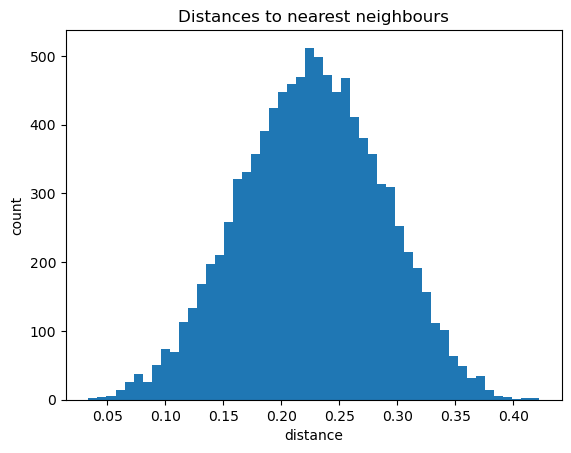

In [24]:
fig, ax = plt.subplots()
ax.hist(dist, bins=50)
ax.set_xlabel("distance")
ax.set_ylabel("count")
ax.set_title("Distances to nearest neighbours");

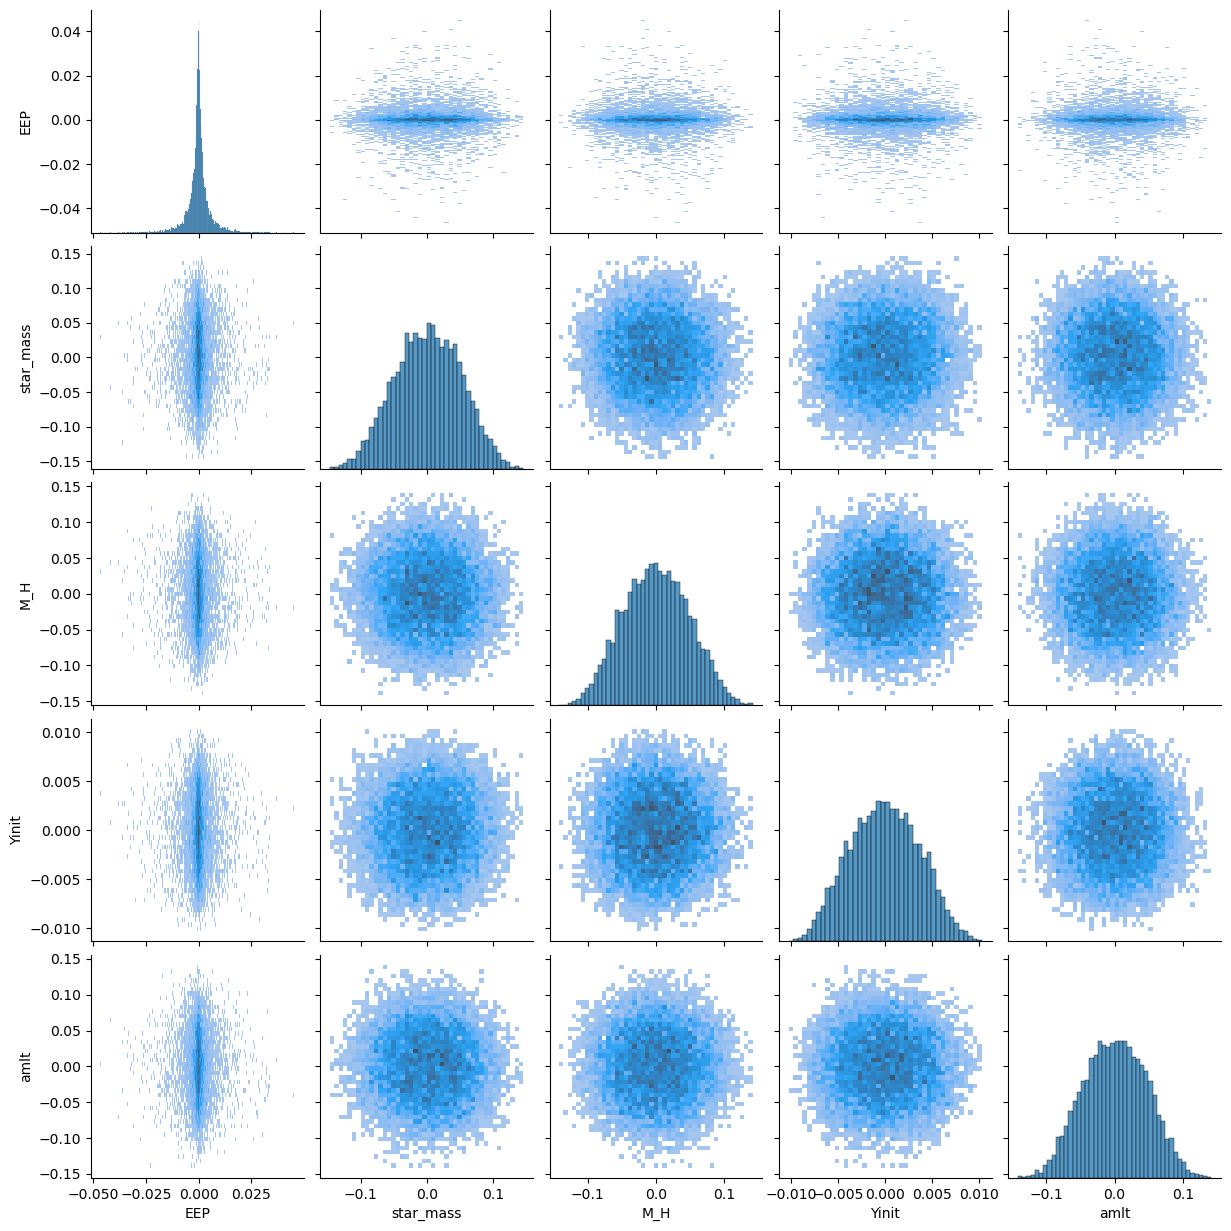

In [25]:
error = test[test_cols].iloc[i] - x
sns.pairplot(error, kind="hist", diag_kind="hist");

In [26]:
error.quantile([.01, .16, .5, .84, .99])

,EEP,star_mass,M_H,Yinit,amlt
0.01,-0.020003,-0.108931,-0.102621,-0.007738,-0.099357
0.16,-0.003407,-0.050572,-0.049820,-0.003993,-0.047777
0.50,0.000021,0.002159,-0.000068,-0.000059,0.001100
0.84,0.003333,0.053456,0.050309,0.003877,0.049192
0.99,0.018532,0.110273,0.104959,0.007963,0.101790


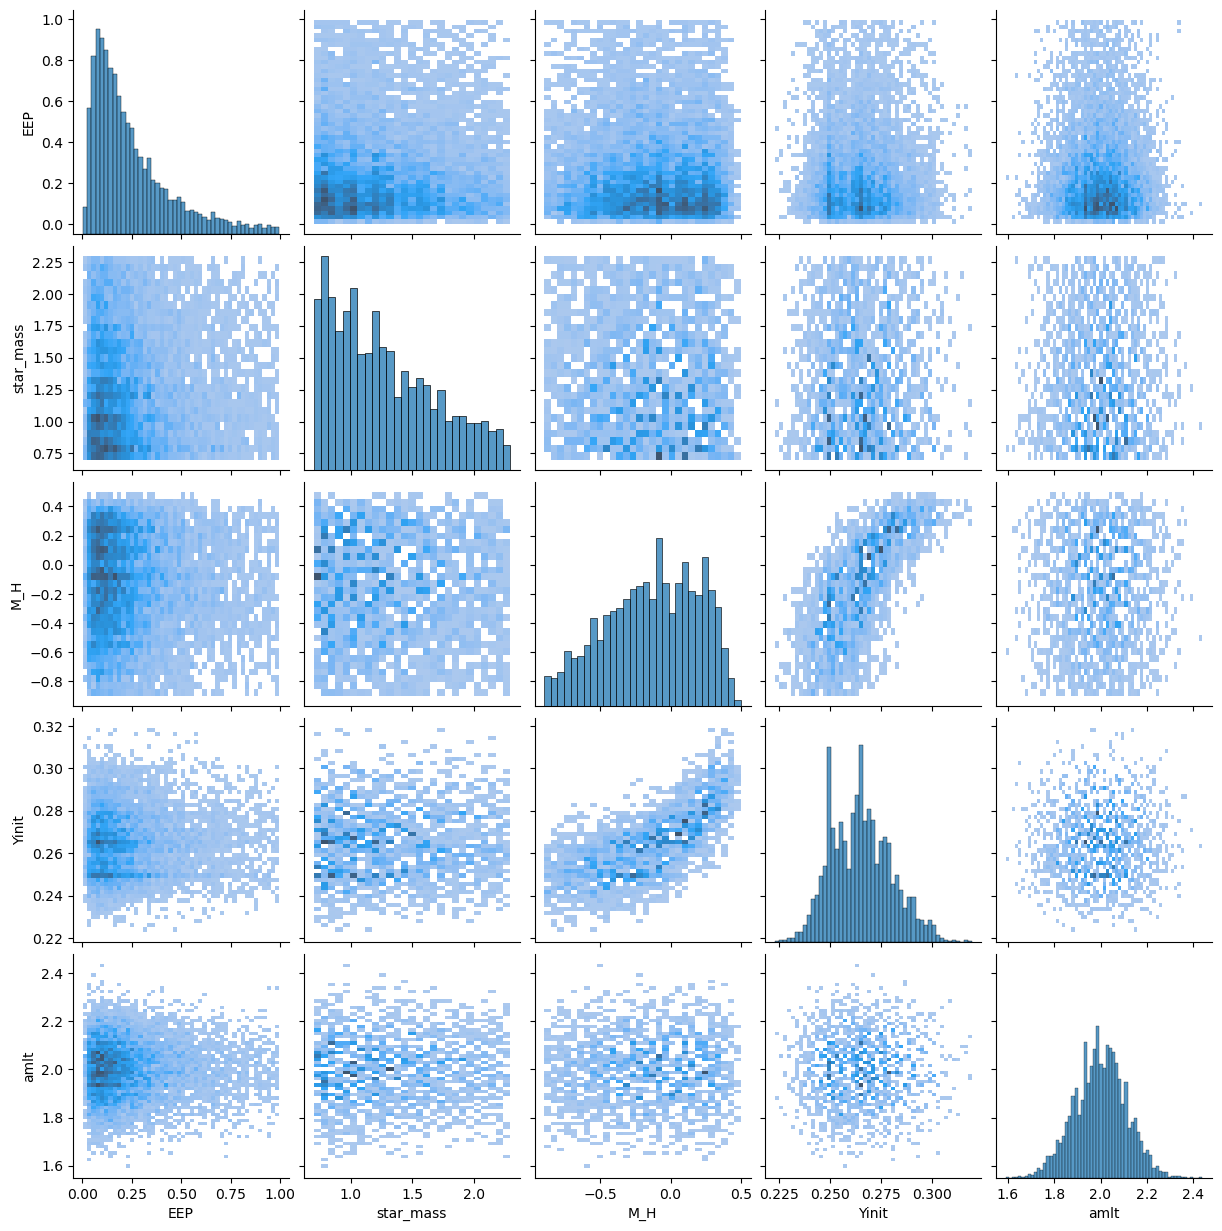

In [27]:
sns.pairplot(test[test_cols].iloc[i], kind="hist", diag_kind="hist");

In [28]:
test[test_cols].iloc[i]

,EEP,star_mass,M_H,Yinit,amlt
3921674,0.056722,1.89009,-0.170616,0.255800,1.957233
1956165,0.237779,0.91519,-0.122002,0.265181,2.112665
1893556,0.091443,2.13394,-0.350517,0.263228,1.877509
1603085,0.164659,0.70542,-0.345757,0.250264,2.017987
2194473,0.090048,0.89565,0.315255,0.281832,1.920575
...,...,...,...,...,...
5608639,0.175984,0.77017,0.129311,0.277944,1.785992
2143197,0.127373,0.81440,-0.217949,0.279879,2.188544
4988918,0.649410,1.96821,0.043251,0.255995,1.938092
3874605,0.587895,1.35259,0.098915,0.272206,1.968170
